## Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
fases = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=fases,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


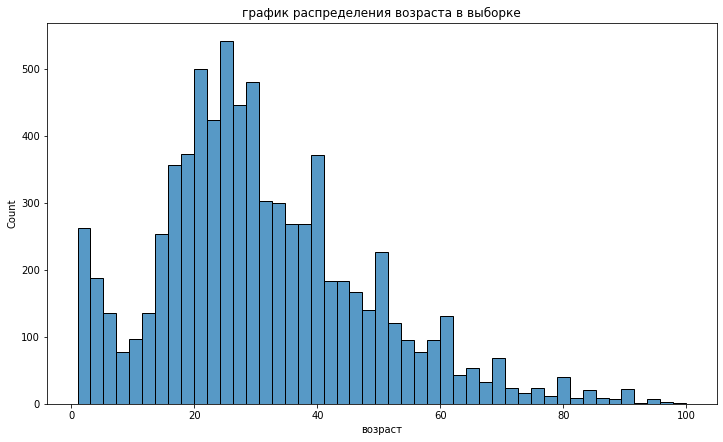

In [ ]:
plt.figure(figsize=(12,7))
sns.histplot(fases['real_age'])
plt.title('график распределения возраста в выборке')
plt.xlabel('возраст');

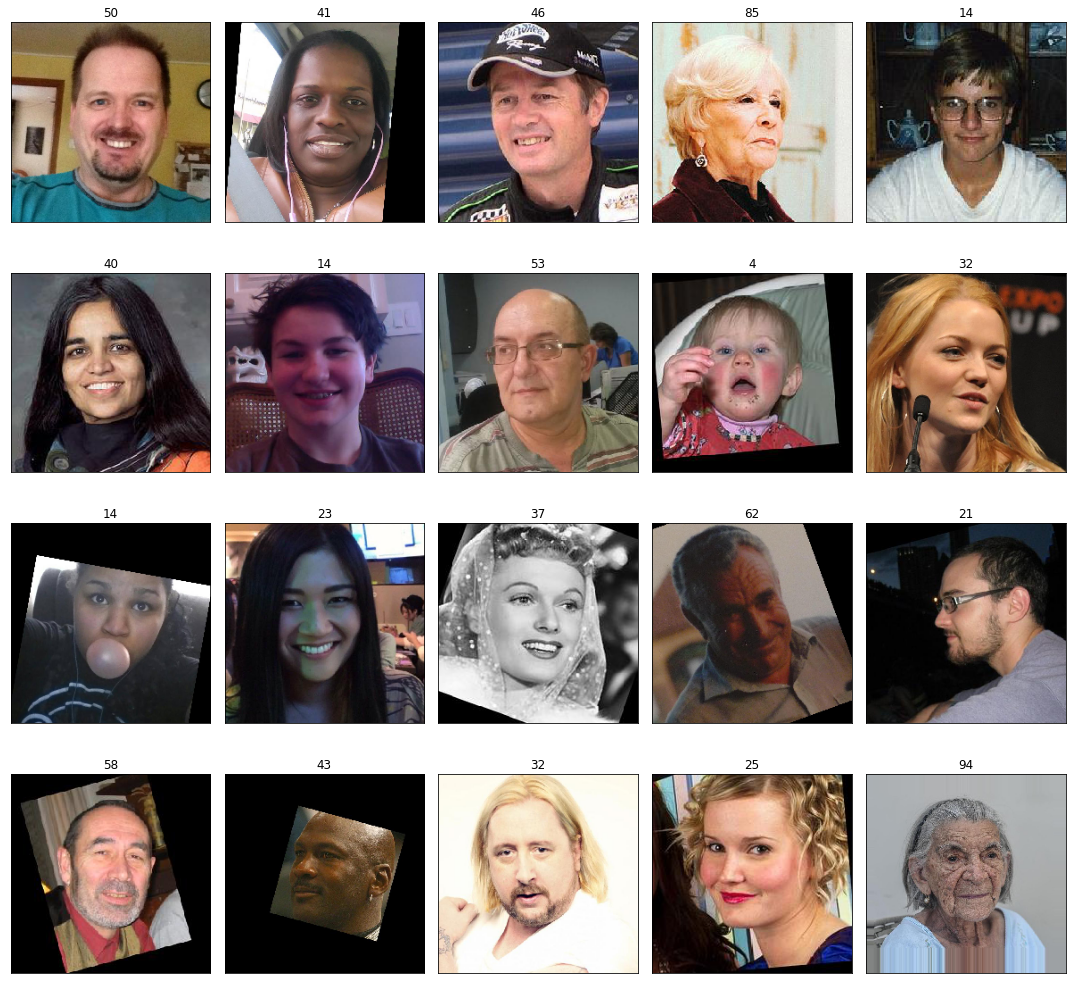

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Выводы по первой части задания:
1. Выборка содержит 7591 фото.
2. Возраст людей в выборке 20-40 лет самый объемный.
3. Напечатала 20: хотела посмотерть больше выборки. При выводе 10-15 фото попадает больше женщин. При выводе 20 становится поровну. Также на снимках представлены люди разных рас и возрастов.
4. Фото расположены крупным планом, анфас.

Выборка богата разнообразными снимками, предполагаю, что модель благодаря этому обучится хорошо.

## Обучение модели

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2, horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, verbose=2, shuffle=True)

    return model

```

```

Train for 380 steps, validate for 95 steps
Epoch 1/5
2023-06-06 19:03:11.147799: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-06 19:03:13.247661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 92s - loss: 207.7989 - mae: 10.5762 - val_loss: 629.5943 - val_mae: 20.0348
Epoch 2/5
380/380 - 37s - loss: 87.3525 - mae: 7.1281 - val_loss: 116.1425 - val_mae: 8.0182
Epoch 3/5
380/380 - 36s - loss: 58.9216 - mae: 5.8934 - val_loss: 93.4272 - val_mae: 7.2703
Epoch 4/5
380/380 - 36s - loss: 41.6859 - mae: 4.9492 - val_loss: 77.6990 - val_mae: 6.7231
Epoch 5/5
380/380 - 36s - loss: 29.1426 - mae: 4.1413 - val_loss: 68.6332 - val_mae: 6.2140
WARNING:tensorflow:sample_weight modes were coerced from

```

## Анализ обученной модели

1. Для выборки была создана нейросеть архитектуры resnet50.
2. Так как это задача регрессии, применены классы и активаторы регрессии.
3. Метрика МАЕ подходит для регрессии. Чем ниже МАЕ, тем точнее предсказания модели.
4. При обучении у меня вышло:
- МАЕ на трен.выборке 4.1413
- МАЕ на тест.выборке 6.2140
Считаю результаты хорошими, а модель годную к работе.
5. Для обучения было выбрано 5 эпох, в среднем обучение занимает 36сек.

6. Где можно использовать данную модель:
- подходит для определения возраста например на кассах самообслуживания. При опредедении возраста клиенту предлагаются дополнительные товары.
- при продаже алкоголя. Над клиентом, если он не достиг 18 лет будет загоряться лампочка для вызова кассира.
- составить анализ среднего возраста посетителей магазина. Посмотреть какая часть посетителей может служить точкой роста прибыли. Например, мало приходит молодежи в пятерочку - завезти товар для них.